In [5]:
# Imports
import pandas as pd
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# Sklearn libraries.
from sklearn import datasets, linear_model, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
import string

from collections import Counter
#deep learning library

import json, os, re, shutil, sys, time
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz

from numpy import random
from numpy.random import multinomial

random.seed(10)


### 1. Load Data

In [6]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [7]:
# Unzip gz file.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

# Load JSON into dataframe.
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [9]:
start = time.time()
df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
end = time.time()
print("Time Used %fs" %(end - start))

Time Used 42.767135s


### 2. Data Exploration

In [5]:
print df.columns

print df['reviewText'][0]

df.head(5)


Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary'],
      dtype='object')
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0000,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0000,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0000,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0000,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0000,"03 15, 2014",Grammy's Angels Love it


#### Exploring helpfulness scores.

In [10]:
helpfulness = []
total_votes = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
        total_votes.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        total_votes.append(i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
total_votes = np.array(total_votes)

In [11]:
# Plot boxplot.
nonnan_helpfulness = helpfulness[~np.isnan(helpfulness)]


#### Exploring review text lengths.

In [12]:
# Remove invalid and nan values.
helpfulness_clean = np.delete(helpfulness, 30730)

nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]



#### Exploring review scores.

### 3. Build Baseline Model

In [13]:
#extract the review text
doc = np.array(df['reviewText'])

# Filter down to reviews with helpfulness scores.
# Remove item with invalid helpfulness score.
doc_clean = np.delete(doc, 30730)
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]
labels = np.reshape(nonnan_helpfulness_clean,(-1,1))

In [14]:
labels_norm = np.rint(labels)

In [69]:
print(np.rint(0.49))
print(np.argmax([0.49,0.49]))
print(len(np.where(y_dev==.50)))

0.0
0
2


### 4. Deep Learning Exploration

#### Build LSTM Model

#### 1.Split the dataset into traing and test 
Delete until next note.

In [15]:
len(nonnan_doc_clean )
msk = np.random.rand(nonnan_doc_clean.shape[0]) <= 0.7

In [16]:
X_train = nonnan_doc_clean[msk]
X_test = nonnan_doc_clean[~msk]
y_train = labels[msk]
y_test = labels[~msk]
y_train_norm = labels_norm[msk]
y_test_norm = labels_norm[~msk]
X_sample = nonnan_doc_clean[0:60000]
y_sample = labels[0:60000]
y_sample_norm = labels_norm[0:60000]

In [11]:
X_train[0]

'For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!'

In [21]:
y_train[0]

array([ 1.])

In [17]:
print (len(X_train))
print (len(X_test))
print (len(y_test))

61126
25894
25894


#### Copied from Le's split to train/test/dev
Revisit deleting above cells.

In [35]:
n_total_samples = len(nonnan_doc_clean)# or whatever it is

indices = np.arange(n_total_samples)
inds_split = multinomial(n=1,
                         pvals=[0.8, 0.1, 0.1],
                         size=n_total_samples).argmax(axis=1)

train_inds = indices[inds_split==0]
test_inds  = indices[inds_split==1]
dev_inds   = indices[inds_split==2]

x_train = nonnan_doc_clean[train_inds]
y_train = labels[train_inds]
y_train_norm = labels_norm[train_inds]
x_test = nonnan_doc_clean[test_inds]
y_test = labels[test_inds]
y_test_norm = labels_norm[test_inds]
x_dev = nonnan_doc_clean[dev_inds]
y_dev = labels[dev_inds]
y_dev_norm = labels_norm[dev_inds]

In [112]:
print (len(x_train))
print (len(x_dev))
print (len(x_test))
print (sum(y_train_norm)/len(x_train))
print (sum(y_dev_norm)/len(x_dev))
print (sum(y_test_norm)/len(x_test))
print (sum(y_dev_norm))
print(sum(np.rint(y_dev)))

69707
8721
8592
[ 0.76878936]
[ 0.77089783]
[ 0.77455773]
[ 6723.]
[ 6723.]


In [91]:
print(x_train[0])
print(x_test[0])

Full and well stitched.  This tutu is a beautiful purple color that looks just like the picture.  It looks just adorable on our little fairy.
For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!


#### 2.Convert the review from list of words to list of word dictionary index

In [37]:
def get_tokens(docs):
    tokens =[]
    for i in docs:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        tokens.extend(token)
    return tokens

tokens = get_tokens(x_train)

In [38]:
# Vocab size.
V = 10000
def build_dataset(words):
    # Leave the last index for all other words.
    count = collections.Counter(words).most_common(V-1)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [39]:
dic, rev_dict = build_dataset(tokens)

In [16]:
len(dic)

9999

In [71]:
max(dic.values())

9998

In [17]:
dic['full']

440

In [51]:
rev_dict[1461]

'c'

In [40]:
def transform_words_to_index(words, dictionary):
    #build sample data
    ids = []
    for i in words:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        j = []
        for w in token:
            if w in dictionary:
                j.append(dictionary[w])
            # Set token_id to vocab size - 1 if word not in top words
            # since this is zero indexed.
            else:
                j.append(V-1)
        ids.append(j)
    return ids

In [41]:
x_train_ids = transform_words_to_index(x_train, dic)
x_dev_ids = transform_words_to_index(x_dev, dic)
x_test_ids = transform_words_to_index(x_test, dic)

In [101]:
print (x_train[0])
print (x_train_ids[0])
print (y_train[0])

print (x_test[0])
print (x_test_ids[0])
print (y_test[0])

print (x_dev[0])
print (x_dev_ids[0])
print (y_dev[0])


Full and well stitched.  This tutu is a beautiful purple color that looks just like the picture.  It looks just adorable on our little fairy.
[455, 2, 46, 2124, 10, 5992, 6, 3, 228, 754, 85, 15, 94, 32, 27, 0, 227, 5, 94, 32, 976, 16, 485, 62, 8944]
[ 1.]
For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!
[7, 86, 1, 582, 7, 141, 9999, 6, 4941, 1088, 1, 77, 3, 544, 2, 9999, 2, 12, 14, 1352, 2, 228, 0, 5992, 6, 25, 455, 2961, 180, 17, 1302, 90, 17, 233, 9999, 1210, 471, 90, 19, 20, 48, 2, 630, 1, 582, 337, 50, 406,

#### 3.Pad the sentence with differnt length

In [42]:
#combine the list of words index and label into a dataframe
train_df = pd.DataFrame(np.column_stack([x_train_ids,y_train]), 
                               columns=['list_words', 'label'])
#combine the list of words index and label into a dataframe
dev_df = pd.DataFrame(np.column_stack([x_dev_ids,y_dev]), 
                               columns=['list_words', 'label'])
#combine the list of words index and label into a dataframe
test_df = pd.DataFrame(np.column_stack([x_test_ids,y_test]), 
                               columns=['list_words', 'label'])

In [43]:
train_df.head()

,list_words,label
0,"[2813, 930, 2, 5, 6, 354, 26, 978, 0, 81, 486,...",0.5000
1,"[0, 1193, 1, 555, 10, 11, 1523, 8475, 3, 913, ...",1.0000
2,"[48, 10, 460, 279, 21, 46, 151, 626, 670, 9999...",0.0000
3,"[0, 121, 2238, 22, 80, 8551, 4, 4501, 10, 3025...",0.8333
4,"[661, 1, 1672, 5, 58, 38, 8, 0, 9999, 8, 7981,...",0.8462


In [117]:
dev_df.head()

,list_words,label
0,"[466, 2, 46, 2180, 10, 6423, 6, 3, 234, 773, 8...",1.0000
1,"[10, 642, 6, 37, 7, 412, 20, 3, 165, 8, 460, 1...",0.5000
2,"[112, 204, 55, 3689, 1831, 3689, 33, 174, 309,...",0.9394
3,"[1, 19, 4, 1672, 1, 22, 44, 833, 135, 3966, 80...",1.0000
4,"[1, 66, 10, 13, 5, 6, 42, 104, 7, 39, 36, 1, 1...",1.0000


In [106]:
test_df.head()

,list_words,label
0,"[7, 86, 1, 582, 7, 141, 9999, 6, 4941, 1088, 1...",0.8750
1,"[1, 56, 938, 0, 4528, 789, 4677, 33, 193, 2, 6...",0.0000
2,"[1572, 3529, 4, 9999, 69, 1186, 6, 893, 194, 1...",0.6667
3,"[1, 22, 2417, 4, 29, 370, 20, 4528, 789, 3227,...",0.0000
4,"[1, 231, 18, 213, 0, 4528, 789, 6802, 1471, 48...",1.0000


In [45]:
class SimpleDataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        return res['list_words'], res['label'] 
    
data = SimpleDataIterator(train_df)
a,b = data.next_batch(3)
print(a)
print(b)

0    [170, 129, 488, 20, 18, 1, 359, 402, 355, 9, 1...
1    [18, 777, 53, 14, 195, 1056, 1, 22, 9999, 108,...
2    [18, 143, 14, 972, 2, 31, 46, 2, 12, 68, 354, ...
Name: list_words, dtype: object
0   1.0000
1   1.0000
2   1.0000
Name: label, dtype: object


In [108]:
##this helps to make sure each sentence have the same length (max_len)
class PaddedDataIterator(SimpleDataIterator):
    def next_batch(self, n, max_len):
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
#             self.max_len = max_len
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        maxlen = max_len
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(res['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = res['list_words'].values[i][:max_len]
            else:
                x_i[:l] = res['list_words'].values[i][:l]

        return x, res['label'] 
    def pad_sentences(self, n, max_len):
        maxlen = max_len
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(self.df['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = self.df['list_words'].values[i][:max_len]
            else:
                x_i[:l] = self.df['list_words'].values[i][:l]

        return x, self.df['label'] 

In [54]:
# This cell is not needed. Just for debugging.
#sample call to get the data
max_length = 100 
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(1,max_length)
batch_x_test, batch_y_test = PaddedDataIterator(test_df).next_batch(1,max_length)
print (batch_x)
print (batch_y)
print (batch_x_test)
print (batch_y_test)

[[  11  414   24 2339   20    0  567 6145   56 2339   20    0  122   88
    29    2 1824   11  783  374   17  578    4 3552    8  134  549    0
  1151  386 1588   29    2 2617   90    0  122    3   96  814    0 1443
    13    3  490 2552    2  147 1288   22   82 6098    0  586 5552  829
     4   11 3189    9 1426 1309  125    1  315  126   10  122    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
0   0.5000
Name: label, dtype: object
[[  41    7   17  205   13  656   16 9999   10   24    3   38   58    9
     0 2974   15  116    6 9999   64   85  123  980  623   73   10 1060
   158 1371  303   64  191  268   25   12  109    4   34   23  142    3
  2609   93   70 3815 1674    6    3  164  130   52   10  980 1674    0
   551    6  910   10    6   19   86    5  191    4   28   28  370    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 

#### 4.build RNN model 

In [98]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf
import sklearn as sk
from tensorflow.contrib import rnn

# Import MNIST data


'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''
######################## 
### MODEL PARAMETERS ###
######################## 


# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 1000
display_step = 1
sentence_size = 150

# Network Parameters
n_input = 10  
n_steps = sentence_size/n_input # timesteps
n_hidden = 20 # hidden layer num of features
n_classes = 2  
vocab_size = 10000


#################################
### PLACEHOLDER AND VARIABLE ###
#################################

# tf Graph input
x = tf.placeholder("int32", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}


######################## 
### DEFINE RNN MODEL ###
######################## 
def MakeFancyRNNCell(H, keep_prob, num_layers=3):
    """Make a fancy RNN cell.
    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.
    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers
    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
      cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
      cell = tf.contrib.rnn.DropoutWrapper(
          cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
      cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


def RNN(x, weights, biases):
    
    with tf.name_scope("Embedding_Layer"):
        C_ = tf.Variable(tf.random_uniform([vocab_size, n_hidden], -1.0, 1.0), name="C")
        # embedding_lookup gives shape (batch_size, N, M)
        test = tf.nn.embedding_lookup(C_, x)
        print(test.shape)
        x_ = tf.reshape(tf.nn.embedding_lookup(C_, x), 
                        [-1, n_steps, n_input*n_hidden], name="x")
        print(x_.shape)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    print(x.shape)
    x = tf.unstack(x_, n_steps, 1)
    print(len(x))
    print(x[0].shape)
    
    with tf.variable_scope("first_lstm109"):
        # Define a lstm cell with tensorflow
#         lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
        lstm_cell = MakeFancyRNNCell(n_hidden, keep_prob = 1.0, num_layers=3)
        # Get lstm cell output
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits_ = RNN(x, weights, biases)



#############################
### LOSS AND OPTIMIZATION ###
#############################

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    
##################
### EVALUATION ###
################## 
pred_ = 1-tf.argmax(logits_,1)
actual_labels_ = 1-tf.argmax(y,1)
correct_pred_ = tf.equal(pred_, actual_labels_)
# correct_pred_ = tf.equal(tf.argmax(logits_,1), tf.argmax(y,1))
accuracy_ = tf.reduce_mean(tf.cast(correct_pred_, tf.float32))



#################
### RUN GRAPH ###
#################

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    iters=[]
    costs=[]
    accs=[]
    f1s=[]
    precisions=[]
    recalls=[]

    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        
        ##########################
        ### GENERATE BATCH X,Y ###
        ##########################
        batch_x, batch_y_1 = PaddedDataIterator(train_df).next_batch(batch_size,sentence_size)
        batch_y = np.concatenate((batch_y_1.reshape([-1,1]), 1-batch_y_1.reshape([-1,1])), axis=1)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        
        
        ################
        ### TRAINING ###
        ################
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        #################
        ### REPORTING ###
        #################
        
        if step % display_step == 0:
            # Calculate batch accuracy, loss
            acc,loss = sess.run([accuracy_,cost], feed_dict={x: batch_x, y: batch_y})
#             precision = sk.metrics.precision_score(acc_labels, preds)
#             precisions.append(precision)
#             recall = sk.metrics.recall_score(acc_labels, preds)
#             recalls.append(recall)
#             f1 = sk.metrics.f1_score(acc_labels, preds)
#             f1s.append(f1)
            iters.append(step*batch_size)
            costs.append(loss)
            accs.append(acc)
#             print( sess.run(pred, feed_dict={x: batch_x, y: batch_y}))
#             print("Iter: %s, Minibatch Loss=%.6f, Training Accuracy=%.5f, F1=%.5f, Precision=%.5f, Recall=%.5f" %(
#                 str(step*batch_size),loss,acc,f1,precision,recall))
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    
    ##########################
    ### EVALUATE WITH DEV DATA ###
    ##########################    
    
    batch_x_dev_1, batch_y_1_dev = PaddedDataIterator(dev_df).next_batch(len(dev_df),sentence_size)
    batch_x_dev = batch_x_dev_1.reshape([-1,n_steps, n_input])
    batch_y_dev = np.concatenate((batch_y_1_dev.reshape([-1,1]), 1-batch_y_1_dev.reshape([-1,1])), axis=1)
#     dev_acc, dev_cost = sess.run([accuracy_, cost],feed_dict={x: batch_x_dev, y: batch_y_dev})
    dev_pred,dev_acc_labels,dev_acc, dev_cost = sess.run([pred_,actual_labels_,accuracy_, cost],
                                                         feed_dict={x: batch_x_dev, y: batch_y_dev})
    precision = sk.metrics.precision_score(dev_acc_labels, dev_pred)
    recall = sk.metrics.recall_score(dev_acc_labels, dev_pred)
    f1 = sk.metrics.f1_score(dev_acc_labels, dev_pred)
    print("F1=%.5f, Precision=%.5f, Recall=%.5f" %(f1,precision,recall))
    


(?, 15, 10, 20)
(?, 15, 200)
(?, 15, 10)
15
(?, 200)


/home/annie_y_lee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:157: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Iter 1000, Minibatch Loss= 0.827758, Training Accuracy= 0.15900
Iter 2000, Minibatch Loss= 0.791579, Training Accuracy= 0.12400
Iter 3000, Minibatch Loss= 0.738968, Training Accuracy= 0.14900
Iter 4000, Minibatch Loss= 0.703044, Training Accuracy= 0.61800
Iter 5000, Minibatch Loss= 0.670938, Training Accuracy= 0.68400
Iter 6000, Minibatch Loss= 0.640666, Training Accuracy= 0.71500
Iter 7000, Minibatch Loss= 0.616729, Training Accuracy= 0.72900
Iter 8000, Minibatch Loss= 0.598243, Training Accuracy= 0.71700
Iter 9000, Minibatch Loss= 0.573190, Training Accuracy= 0.75300
Iter 10000, Minibatch Loss= 0.581601, Training Accuracy= 0.72900
Iter 11000, Minibatch Loss= 0.569239, Training Accuracy= 0.75400
Iter 12000, Minibatch Loss= 0.560820, Training Accuracy= 0.77700
Iter 13000, Minibatch Loss= 0.565153, Training Accuracy= 0.77100
Iter 14000, Minibatch Loss= 0.569633, Training Accuracy= 0.79100
Iter 15000, Minibatch Loss= 0.550210, Training Accuracy= 0.82700
Iter 16000, Minibatch Loss= 0.5535

/home/annie_y_lee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:195: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


F1=0.92160, Precision=0.85460, Recall=1.00000


In [109]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    batch_x_dev_1, batch_y_1_dev = PaddedDataIterator(dev_df).pad_sentences(len(dev_df),sentence_size)
    batch_x_dev = batch_x_dev_1.reshape([-1,n_steps, n_input])
    batch_y_dev = np.concatenate((batch_y_1_dev.reshape([-1,1]), 1-batch_y_1_dev.reshape([-1,1])), axis=1)
    actual_labels = sess.run([actual_labels_], feed_dict={y: batch_y_dev})

/home/annie_y_lee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [122]:
print(len(dev_df))
print(np.sum(actual_labels))
print(sum(batch_y_dev))
print(len(batch_y_1_dev))
print(sum(1-np.argmax(batch_y_dev,1)))
print(actual_labels[:20])
print(batch_y_dev[0:20,0])

8721
7453
[6833.930572284097 1887.0694277159266]
8721
7453
[array([1, 0, 1, ..., 1, 1, 1])]
[1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.5 1.0 0.0 0.0 1.0 0.0
 0.8888888888888888 1.0 1.0]


In [99]:
print(dev_pred[:100])
print(sum(dev_pred))
print(dev_acc_labels[:100])
print(sum(dev_acc_labels))
print(len(dev_acc_labels))
print(dev_acc)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
8721
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
7453
8721
0.854604


In [70]:
def computeDevScores():
    precision = sk.metrics.precision_score(dev_acc_labels, dev_pred)
    recall = sk.metrics.recall_score(dev_acc_labels, dev_pred)
    f1 = sk.metrics.f1_score(dev_acc_labels, dev_pred)
    print("F1=%.5f, Precision=%.5f, Recall=%.5f" %(f1,precision,recall))
    precision2 = sk.metrics.precision_score(y_dev_norm, dev_pred)
    recall2 = sk.metrics.recall_score(y_dev_norm, dev_pred)
    f12 = sk.metrics.f1_score(y_dev_norm, dev_pred)
    print("F1=%.5f, Precision=%.5f, Recall=%.5f" %(f12,precision2,recall2))

In [147]:
# With 1 layer
computeDevScores()

F1=0.92876, Precision=0.87040, Recall=0.99551


In [71]:
# With 3 layers
computeDevScores()

F1=0.93210, Precision=0.87284, Recall=1.00000
F1=0.87063, Precision=0.77090, Recall=1.00000


In [119]:
def computeTestAccuracy():
    batch_x_test_1, batch_y_1_test = PaddedDataIterator(test_df).next_batch(len(test_df),sentence_size)
    batch_x_test = batch_x_test_1.reshape([-1,n_steps, n_input])
    batch_y_test = np.concatenate((batch_y_1_test.reshape([-1,1]), 1-batch_y_1_test.reshape([-1,1])), axis=1)
    test_acc, test_cost = sess.run([accuracy, cost], feed_dict={x: batch_x_test, y: batch_y_test})
    print ("Test Accuracy:",test_acc)

In [114]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt

def visualizeTraining(iters, costs, accs):

    x = iters
    y = costs
    z = accs

    plt.scatter(x, y )
    plt.xlabel('iterations')
    plt.ylabel('cost')
    plt.show()

    plt.scatter(x, z)
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.show()

    print ("Dev Accuracy:",dev_acc)
    print("Dev cost:",dev_cost)    

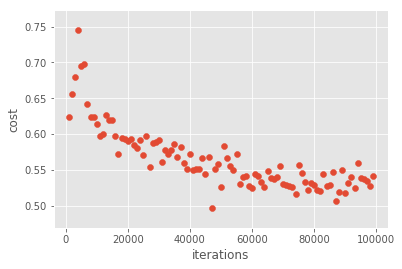

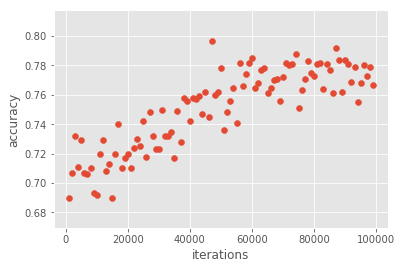

Testing Accuracy: 0.752
Testing cost: 0.562688


In [28]:
# Original without FancyRNN
visualizeTraining(iters, costs, accs)

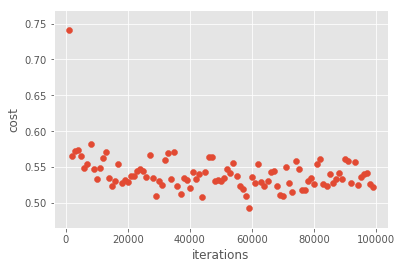

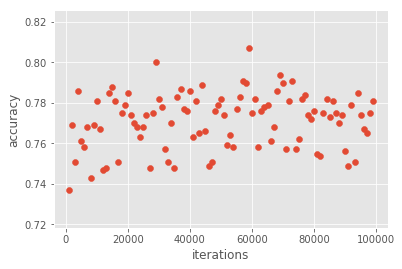

Testing Accuracy: 0.777
Testing cost: 0.530469


In [31]:
# Changed to Fancy RNN
# 1.0 keep_prob
# 1 layer
visualizeTraining(iters, costs, accs)

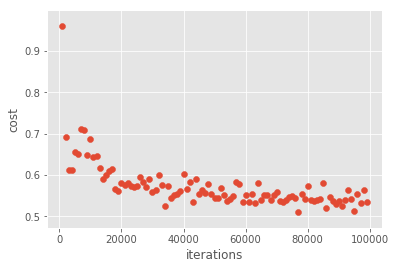

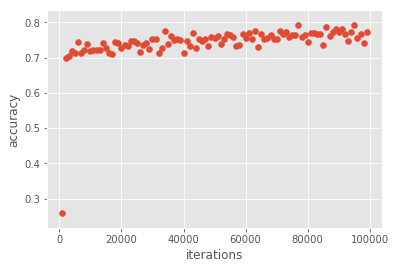

Testing Accuracy: 0.77
Testing cost: 0.536199


In [33]:
# Changed to Fancy RNN (2nd run same settings)
# 1.0 keep_prob
# 1 layer
visualizeTraining(iters, costs, accs)

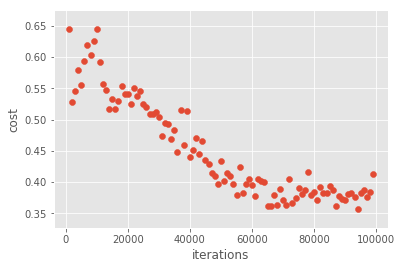

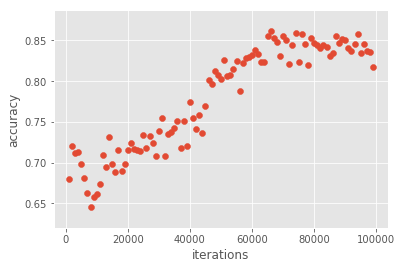

Testing Accuracy: 0.85
Testing cost: 0.383113


In [58]:
# Original without FancyRNN but using prob instead of one-hot
visualizeTraining(iters, costs, accs)

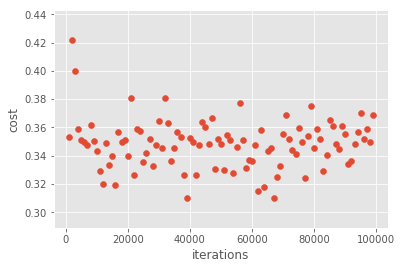

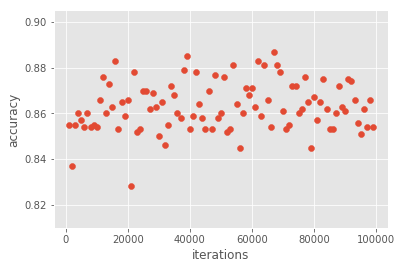

Testing Accuracy: 0.856
Testing cost: 0.364555


In [60]:
# Default FancyRNN but using prob instead of one-hot
visualizeTraining(iters, costs, accs)

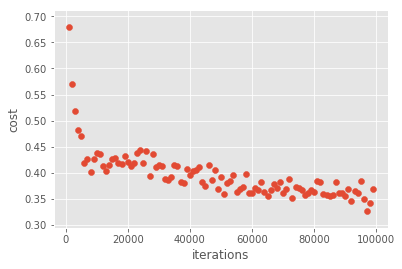

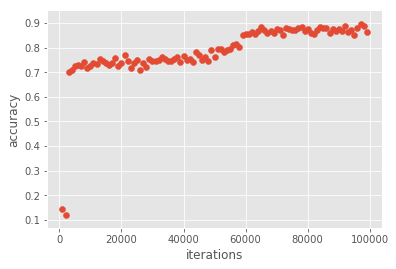

Testing Accuracy: 0.867
Testing cost: 0.362405


In [62]:
# Default FancyRNN but using prob instead of one-hot
# 2 LSTM layers
visualizeTraining(iters, costs, accs)

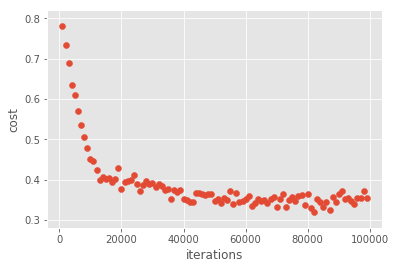

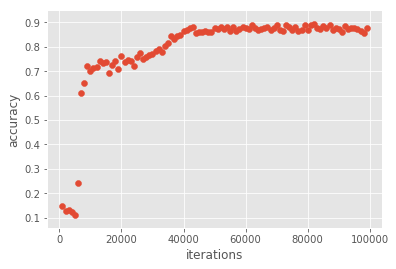

Testing Accuracy: 0.878
Testing cost: 0.348885


In [64]:
# Default FancyRNN but using prob instead of one-hot
# 3 LSTM layers
visualizeTraining(iters, costs, accs)

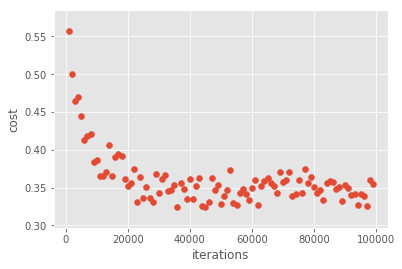

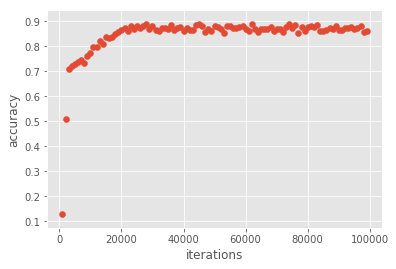

Dev Accuracy: 0.870905
Dev cost: 0.341749


In [123]:
# Default FancyRNN but using prob instead of one-hot
# 3 LSTM layers
visualizeTraining(iters, costs, accs)

In [120]:
# Compute Test Accuracy
computeTestAccuracy()

/home/annie_y_lee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


RuntimeError: Attempted to use a closed Session.

### Scratch below

In [177]:
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(batch_size,100)

In [159]:
batch_x

array([[   5,  176,   34,   33,   55,  473,    5,  371,   68,  111,    4,
        2523,  133,    5,   34,  371,    3,  140,  539,    2,   55,    1,
        2409,   22,    1,   64,  210,   20,  237,    5,  175,  335,   21,
           5,  193,  271,    5, 1097,  326,   53,    1,  216,   57,    9,
        1349,    1,   17,   10,  150,   15,  266,    4,  213,   31, 2480,
           9,  849,    1,   17,   15, 2183, 1508,  426,   11,   15,  352,
          13, 2397,  432,    4,    3,  179, 1624,   40,    0, 2087,  663,
           4,  891,  819,    2,  215,  192,   11,  512,    0,  266,  822,
           7,    3,   62,  207,   23,    1,   43,    2,  612,    5,  125,
          23],
       [   1,  182,   10,   91,    3,   62,  100,    3,  160,  329,  136,
          12,    1,   78,  451,   13,    5,    1,  263,    2,  968,    5,
           1,  124,    5,   16, 1273,    4, 1381,   36,   43,  131, 2129,
        1394,    0, 1723,    4,   17,  101,  692,    0, 1882,   11,    0,
        1361, 2415, 206

In [163]:
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(batch_size,100)
batch_x = batch_x.reshape((batch_size, n_steps, n_input))

x = tf.unstack(x, n_steps, 1)

In [161]:
tf.unstack(x, n_steps, 1)

[<tf.Tensor 'unstack_5:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:1' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:2' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:3' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:4' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:5' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:6' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:7' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:8' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:9' shape=(?, 10) dtype=float32>]

In [156]:
from tensorflow.contrib import rnn

In [ ]:
##define variables 
n_hidden = 10 
with tf.variable_scope("softmax"):
    W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
    b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")

with tf.variable_scope("recurrent"):
    rnn_cell = rnn.BasicLSTMCell(n_hidden)
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    initial_h_ = self.cell_.zero_state(self.batch_size_,dtype=tf.float32)
    outputs, self.final_h_ = tf.nn.dynamic_rnn(self.cell_, inputs=self.x_,initial_state=self.initial_h_, sequence_length=100)



In [196]:
def MakeFancyRNNCell(H, keep_prob, num_layers=1):
    """Make a fancy RNN cell.

    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.

    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers

    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
        cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
        cell = tf.contrib.rnn.DropoutWrapper(
        cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
        cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


In [36]:
##have to fix here!!!
def RNN(x):
    n_hidden = 10 
    with tf.variable_scope("softmax"):
        W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
        b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")
    # reshape to [1, n_input]
    n_input = len(x)
    x = tf.reshape(x, [-1, n_input])

    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    x = tf.split(x,n_input,1)
#     print x
    # 1-layer LSTM with n_hidden units.
#     with tf.variable_scope('cell_def'):
#         lstm_cell = MakeFancyRNNCell(H=n_hidden,keep_prob=1)
    lstm_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden, forget_bias=0.0)
#     print x
    # generate prediction

    
#     with tf.variable_scope('rnn_def',reuse=True):
    initial_h_ = lstm_cell.zero_state(1,dtype=tf.int32)
    outputs,final_h_ = tf.contrib.rnn.static_rnn(lstm_cell, x,dtype=tf.int32)
            
            

    # there are n_input outputs but
    # we only want the last output
    return tf.matmul(outputs[-1], W_out_) + b_out_

In [37]:
import tensorflow as tf
from tensorflow.contrib import rnn


learning_rate =0.1
pred = RNN(X_sample_ids[0])

# Loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_sample[0]))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

AttributeError: 'module' object has no attribute 'static_rnn'

In [ ]:
_, loss, onehot_pred = session.run([optimizer, cost, pred], 
                                        feed_dict={x: symbols_in_keys, y: symbols_out_onehot})

### Scratch below

In [17]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(60843,)
(26177,)
(60843, 1)
(26177, 1)


In [18]:
X_sample = nonnan_doc_clean[0:100]
y_sample = y[0:100]

In [19]:
print len(X_sample[0].split())
print X_sample[0]
print y[0]

35
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++
[ 0.875]


In [22]:
len(nltk.corpus.__getattr__('brown').words())

1161192

In [86]:
corpus = X_sample[0].split()
bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)

In [87]:
for i, (w,y) in enumerate(bi):
    print w
    print y_sample[0]

[['For' 'what' 'I' 'paid' 'for' 'two' 'tutus' 'is' 'unbeatable' 'anywhere!'
  'I' 'ordered' 'a' 'pink' 'and' 'turquios' 'and' 'they' 'are' 'vibrant'
  'and' 'beautiful!' 'The' 'tutu' 'is' 'very' 'full!' 'Princess' 'style!'
  'Not' 'cheaply' 'made!' 'Not' 'cheap' 'materia!' 'Obviously' 'someone'
  'made' 'these' 'with' 'love' 'and' 'care!' 'I' 'paid' 'less' 'than' '7'
  'bucks' 'for' 'a' 'tutu' 'I' 'and' 'I' 'feel' 'proud' 'of' 'my' 'self'
  'for' 'researching' 'to' 'the' 'point' 'of' 'finding' 'gold!Recommend'
  '2-6' 'years!My' 'daughter' 'is' 'two' '!' 'Wears' 'size' '4t' 'and'
  'this' 'skirt' '(' 'one' 'size' ')' 'fit' 'perfect' 'and' 'will'
  'probaly' 'be' 'able' 'to' 'accommodate' 'her' 'quickly' 'growing'
  'waist' 'for' 'some']]
[ 0.875]


In [99]:
import rnnlm
# import rnnlm_test
reload(rnnlm)
# reload(rnnlm_test)

<module 'rnnlm' from 'rnnlm.py'>

In [92]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        #### YOUR CODE HERE ####
        
        feed_dict = {lm.input_w_:w,
                 lm.target_y_:y,
                 lm.learning_rate_:learning_rate,
                 lm.initial_h_ : h}
            
        cost, _, h = session.run([loss, train_op,lm.final_h_],
                       feed_dict=feed_dict)
        
        
            
            
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print "[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost)
            tick_time = time.time()  # reset time ticker

    return total_cost / total_batches

In [93]:
V=1000
max_time = 20
batch_size = 50
learning_rate = 0.5
num_epochs = 5

# Model parameters
model_params = dict(V=100, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=1)

# TF_SAVEDIR = "tf_saved"
# checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
# trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [101]:
# Will print status every this many seconds
import rnnlm
# import rnnlm_test
reload(rnnlm)
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
# shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
# if not os.path.isdir(TF_SAVEDIR):
#     os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
#         bi = utils.batch_generator(train_ids, batch_size, max_time)
        corpus = X_sample[0].split()
        bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)
        for i, (w,y) in enumerate(bi):
            w1=w
            
        bi= (w1,y_sample[y])
        print "[epoch %d] Starting epoch %d" % (epoch, epoch)
        #### YOUR CODE HERE ####
        # Run a training epoch.
        cost = run_epoch(lm, session, bi, 
                     learning_rate=learning_rate, train=True, 
                     verbose=False, tick_s=3600)

        #### END(YOUR CODE) ####
        print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
        ##
        # score_dataset will run a forward pass over the entire dataset
        # and report perplexity scores. This can be slow (around 1/2 to 
        # 1/4 as long as a full epoch), so you may want to comment it out
        # to speed up training on a slow machine. Be sure to run it at the 
        # end to evaluate your score.
        print ("[epoch %d]" % epoch),
        #score_dataset(lm, session, train_ids, name="Train set")
        print ("[epoch %d]" % epoch),
        score_dataset(lm, session, test_ids, name="Test set")
        print ""
    
    # Save final model
    saver.save(session, trained_filename)

ValueError: Dimension must be 2 but is 3 for 'recurrent/transpose' (op: 'Transpose') with input shapes: [?,100], [3].

## Scratch Below

In [ ]:
print 1

In [62]:
import nltk
nltk.download('brown')

corpus = nltk.corpus.brown

[nltk_data] Downloading package brown to /Users/legu/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [72]:
!pip install vocabulary

    100% |████████████████████████████████| 593kB 408kB/s 
    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 102kB 1.2MB/s 
  Running setup.py bdist_wheel for vocabulary ... - \ done
  Stored in directory: /Users/legu/Library/Caches/pip/wheels/36/6c/c0/92bb20f79402d055c3bce3e89d9f2cce5d6937bc2aadc0fb45
Successfully built vocabulary
  Found existing installation: requests 2.11.1
    Uninstalling requests-2.11.1:
      Successfully uninstalled requests-2.11.1
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import utils
import vocabulary
# train_sents, test_sents = utils.get_train_test_sents(corpus, split=0.8, shuffle=True)
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(corpus))
print "Train set vocabulary: %d words" % vocab.size

AttributeError: 'module' object has no attribute 'Vocabulary'